# Part IV: Point Cloud Processing

In [2]:
import time
import progressbar
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import open3d
import trimesh
print("Trimesh version:", trimesh.__version__)

WARNING - 2022-10-23 21:55:52,603 - graph - graph-tool unavailable, some operations will be much slower
WARNING - 2022-10-23 21:55:52,679 - assimp - pyassimp unavailable, using only native loaders
WARNING - 2022-10-23 21:55:52,704 - creation - shapely.geometry.Polygon not installed, some functions will not work!


Trimesh version: 2.3.13


In [12]:
vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

# Make sure you call this function to draw the points for proper viewing direction
def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1, 0))
    view_ctl.set_front((0, 2, 1))
    view_ctl.set_lookat((0, 0, 0))
    view_ctl.set_zoom(1)
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(10,8))
    plt.imshow(np.asarray(img))
    for g in geoms:
        vis.remove_geometry(g)

def create_arrow_from_vector(origin, vector):
    '''
    origin: origin of the arrow
    vector: direction of the arrow
    '''
    v = np.array(vector)
    v /= np.linalg.norm(v)
    z = np.array([0,0,1])
    angle = np.arccos(z@v)
    
    arrow = open3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.02, cone_radius=0.05, cylinder_height=0.12, 
                                                      cone_height=0.1)
    arrow.paint_uniform_color([1,0,1])
    T = np.eye(4)
    T[:3, 3] = np.array(origin)
    T[:3,:3] = open3d.geometry.get_rotation_matrix_from_axis_angle(np.cross(z, v) * angle)
    arrow.transform(T)
    return arrow

## Load and display original saddle object

(729, 3) (676, 3) 0 728


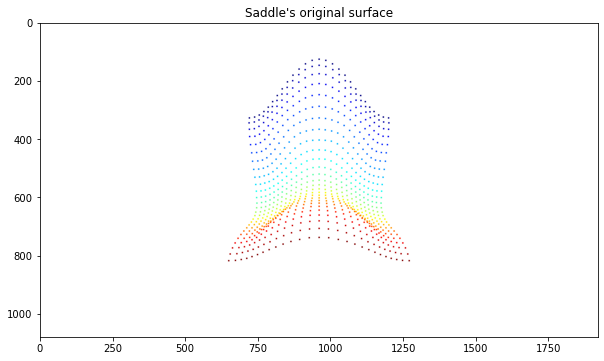

In [13]:
mesh_saddle = trimesh.load('../data/saddle.obj')
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(mesh_saddle.vertices)
draw_geometries([pcd])
plt.title("Saddle's original surface")

print(mesh_saddle)
print(mesh_saddle.vertices.shape, mesh_saddle.faces.shape, mesh_saddle.faces.min(), mesh_saddle.faces.max())
# print(mesh_saddle.vertices)
# print(mesh_saddle.faces)

## 4.1 Sample 100k points uniformly on the surface

In [36]:
# unif_samples = trimesh.sample.sample_surface(mesh_saddle, count=num_unif_samples)
unif_samples = trimesh.sample.sample_surface_even(mesh_saddle, count=100000)
num_unif_samples = unif_samples.shape[0]
# print(unif_samples.shape)

## Display 100k uniformly sampled points

Text(0.5, 1.0, "Saddle's 100K Uniformly Sampled Surface")

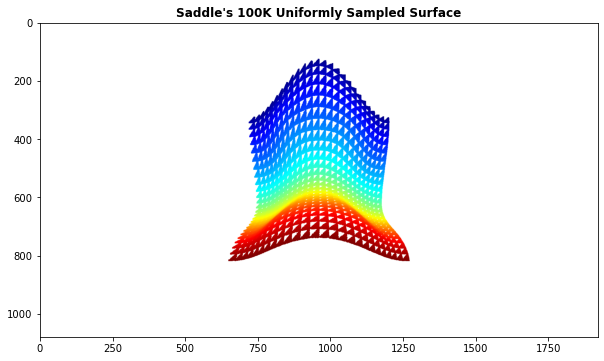

In [37]:
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(unif_samples)
draw_geometries([pcd])
plt.title("Saddle's 100K Uniformly Sampled Surface", fontweight ="bold")

## 4.2 Iterative farthest point sampling method (IFPS)

In [38]:
start_time = time.time()

num_ifps_samples = 4000

# initialize an array for storing indices of remaining points
rem_pts_idx = np.arange(num_unif_samples)   # [0,1,2,...,99999]

# initialize an array for storing sampled/selected points indices
sampled_pts_idx = np.zeros(num_ifps_samples, dtype='int')  # (4000,)

# initialize distances to infinity
dists = np.ones_like(rem_pts_idx) * float('inf')  # (100000,)

# select a random point from unif_samples and add it to sampled points
selected_pt_idx = 0
# selected_pt_idx = np.random.randint(0, num_unif_samples)
sampled_pts_idx[0] = rem_pts_idx[selected_pt_idx]

# delete the selected point index from remaining points indices list
rem_pts_idx = np.delete(rem_pts_idx, selected_pt_idx)  # (99999,)

# iteratively select points from unif_samples and add it to sampled_pts
for i in tqdm(range(1, num_ifps_samples)):
    last_added_pt_idx = sampled_pts_idx[i-1]
    
    vec_to_last_added_pt = unif_samples[rem_pts_idx] - unif_samples[last_added_pt_idx]
    dist_to_last_added_pt = np.linalg.norm(vec_to_last_added_pt, axis=1)
    dists[rem_pts_idx] = np.minimum(dist_to_last_added_pt, dists[rem_pts_idx])
    
    selected_pt_idx = np.argmax(dists[rem_pts_idx])
    sampled_pts_idx[i] = rem_pts_idx[selected_pt_idx]
    
    rem_pts_idx = np.delete(rem_pts_idx, selected_pt_idx)

ifps_samples = unif_samples[sampled_pts_idx]
print("IFPS sampled points shape:", ifps_samples.shape)

print("Time elapsed:", round(time.time() - start_time, 3), 's')

  0%|          | 0/3999 [00:00<?, ?it/s]

IFPS sampled points shape: (4000, 3)
Time elapsed: 33.632 s


## Display the 4k point cloud sampled using IFPS method

Text(0.5, 1.0, "Saddle's 4K IFPS sampled surface")

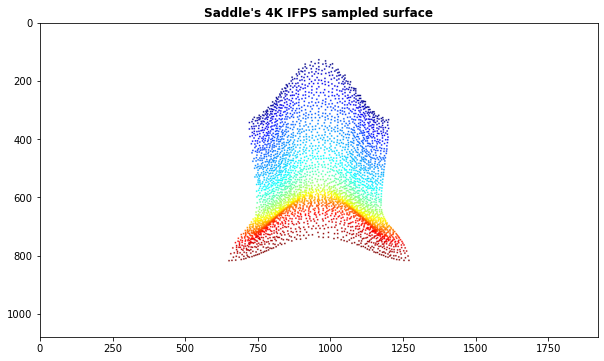

In [39]:
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(ifps_samples)
draw_geometries([pcd])
plt.title("Saddle's 4K IFPS sampled surface", fontweight ="bold")

## 4.3 Estimation of normal vector at 4k sampled points using PCA

In [42]:
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(ifps_samples)
geometry_lst = [pcd]

start_time = time.time()

num_NN_pts = 50
dists = np.zeros(num_unif_samples, dtype='float')
normal_vecs = np.zeros_like(ifps_samples)

# iterate through 4K sampled points and estimate normal at each point
for i in tqdm(range(num_ifps_samples)):
    pt_idx = sampled_pts_idx[i]
    sampled_pt = unif_samples[pt_idx]
    
    dists = np.linalg.norm(unif_samples - sampled_pt, axis=1)  # (100000,)
    idx_sorted_using_dists = np.argsort(dists)  # (100000,)
    assert(idx_sorted_using_dists[0] == pt_idx)
    
    NN_indices = idx_sorted_using_dists[1:num_NN_pts+1]  # (50,)
    
    # compute normal vector for each point using PCA
    x_mean = np.mean(unif_samples[NN_indices], axis=0)    # (3,)
    xi_minus_mean = (unif_samples[NN_indices] - x_mean)    # 50x3
    xi_cov_mat = np.matmul(xi_minus_mean.T, xi_minus_mean) / (num_NN_pts-1)   # 3x3
    
    eigenvals, eigenvecs = np.linalg.eig(xi_cov_mat)    # (3,), (3,3)
    normal_vec = eigenvecs[:, np.argmin(eigenvals)]
    normal_vec = normal_vec / np.linalg.norm(normal_vec)
    
    # orient normals so that they roughly point in the Y-direction
    if normal_vec[1] < 0:
        normal_vec *= -1
    normal_vecs[i] = normal_vec
    
    # drawing normals at every 50 iterations
    if (i % 25 == 0):
        arrow = create_arrow_from_vector(origin=sampled_pt, vector=normal_vec)
        geometry_lst.append(arrow)

print("Normal Vecs shape:", normal_vecs.shape)
print("Time elapsed:", round(time.time() - start_time, 3), 's')

  0%|          | 0/4000 [00:00<?, ?it/s]

Normal Vecs shape: (4000, 3)
Time elapsed: 64.918 s


## Plotted normal vectors for every 25 points for display

Text(0.5, 1.0, "Saddle's 4K IFPS sampled + normal surface")

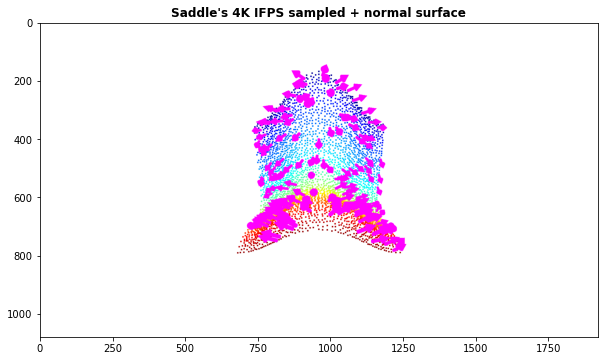

In [43]:
draw_geometries(geometry_lst)
# open3d.visualization.draw_geometries(geometry_lst)
plt.title("Saddle's 4K IFPS sampled + normal surface", fontweight ="bold")

In [58]:
# pcd = open3d.geometry.PointCloud()
# pcd.points = open3d.utility.Vector3dVector(ifps_samples)
# downpcd = open3d.geometry.voxel_down_sample(pcd, voxel_size=0.05)
# open3d.geometry.estimate_normals(downpcd, search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=0.1,max_nn=30))

# open3d.visualization.draw_geometries([downpcd])

## 4.4 Principal curvature estimation for point cloud (using modified Rusinkiewicz's method)

### Algorithm
- Iteratively go over each point cloud in the 4k points. 
- To apply Rusinkiewitz's method, we need faces using which we can define edges, face normals and vertex normals. 
- For each point p, we sample nearby neighbouring points in the point cloud within an L2-ball of radius $\epsilon$.
- For these sampled points and point p, we compute vector joining p to all the sampled points
- Next, for each vector v, we compute the dot products with other vectors in order to find two vectors in the sampled points which are most aligned with the vector v. 
- Now, using vector v and two aligned vectors, form two triangles or two faces and store their vertex indices
- Keep repeating above steps for all the 4k sampled points to get mesh vertices and mesh faces
- Apply the standard Rubinkievitz's method on this mesh and compute the shape operator and hence the principal curvature for each faces
- For each point in the point cloud, compute its principal curvature by taking weighted mean of the principal curvatures of all the faces containing this point

In [48]:
def compute_face_normals(mesh_vertices, mesh_faces):
    num_faces = mesh_faces.shape[0]
    num_vertices = mesh_vertices.shape[0]

    face_normals = []
    
    for itr in tqdm(range(num_faces)):
        vertices_idx = mesh_faces[itr]   # (3,)
        vertices = mesh_vertices[vertices_idx]   # 3x3

        # compute edge vectors for each face
        edges = np.zeros((3,3))
        edges[0] = vertices[2] - vertices[1]
        edges[1] = vertices[0] - vertices[2]
        edges[2] = vertices[1] - vertices[0]

        # compute face orthonormal basis vectors using Gram-Schmidt orthogonalization
        Dfp = np.zeros((3,2))
        Dfp[:,0] = edges[0]
#         assert(np.dot(edges[0], edges[0]) - np.linalg.norm(edges[0])**2 <= 1e-10)
        proj_component = (np.dot(edges[1], edges[0]) / np.dot(edges[0], edges[0])) * edges[0]
        Dfp[:,1] = edges[1] - proj_component
        Dfp = Dfp / np.linalg.norm(Dfp, axis=0)
#         assert(np.dot(Dfp[:,0], Dfp[:,1]) <= 1e-10)

        # compute face normal
        face_normal = np.cross(Dfp[:,0], Dfp[:,1])
        face_normals.append(face_normal)
    
    face_normals = np.array(face_normals)
    return face_normals

In [53]:
def compute_shape_operator(mesh_vertices, mesh_faces):
    num_faces = mesh_faces.shape[0]
    num_vertices = mesh_vertices.shape[0]

    start_time = time.time()
    
    # compute face normals
    face_normals = compute_face_normals(mesh_vertices, mesh_faces)
#     face_normals = mesh.face_normals
    
    # compute vertex normals
    vertex_normals = trimesh.geometry.mean_vertex_normals(num_vertices, mesh_faces, face_normals)
#     pcd.estimate_normals(open3d.geometry.KDTreeSearchParamKNN(knn=50))
    
    principal_curv = np.zeros((num_faces, 2))

    for itr in tqdm(range(num_faces)):
        vertices_idx = mesh_faces[itr]   # (3,)
        vertices = mesh_vertices[vertices_idx]   # 3x3

        # compute edge vectors for each face
        edges = np.zeros((3,3))
        edges[0] = vertices[2] - vertices[1]
        edges[1] = vertices[0] - vertices[2]
        edges[2] = vertices[1] - vertices[0]

        # compute face orthonormal basis vectors using Gram-Schmidt
        Dfp = np.zeros((3,2))
        Dfp[:,0] = edges[0]
        proj_component = (np.dot(edges[1], edges[0]) / np.dot(edges[0], edges[0])) * edges[0]
        Dfp[:,1] = edges[1] - proj_component
        Dfp = Dfp / np.linalg.norm(Dfp, axis=0)
        assert(np.dot(Dfp[:,0], Dfp[:,1]) <= 1e-10)

        lhs1 = np.matmul(Dfp.T, edges[0])
        rhs1 = np.matmul(Dfp.T, vertex_normals[vertices_idx[2]] - vertex_normals[vertices_idx[1]])

        lhs2 = np.matmul(Dfp.T, edges[1])
        rhs2 = np.matmul(Dfp.T, vertex_normals[vertices_idx[0]] - vertex_normals[vertices_idx[2]])

        lhs3 = np.matmul(Dfp.T, edges[2])
        rhs3 = np.matmul(Dfp.T, vertex_normals[vertices_idx[1]] - vertex_normals[vertices_idx[0]])

        A = np.array([lhs1, lhs2, lhs3]).T
        B = np.array([rhs1, rhs2, rhs3]).T

        S = np.matmul(np.matmul(B, A.T), np.linalg.inv(np.matmul(A, A.T)))
        
        principal_curv[itr], _ = np.linalg.eig(S)
    
    print("Time taken:", round(time.time() - start_time, 3), 's')
    
    return principal_curv

In [51]:
eps_radius = 0.1

mesh_faces = []
mesh_vertices = []

for itr in tqdm(range(num_ifps_samples)):
    sampled_pt = ifps_samples[itr]    # (3,)
    mesh_vertices.append(sampled_pt)
    
    dists = np.linalg.norm(ifps_samples - sampled_pt, axis=1)   # (4000,)
    idx_sorted_dists = np.argsort(dists)   # (4000,)
#     plt.hist(dists, bins='auto')

    nn_pts_idx = np.where(np.logical_and(dists > 0, dists < eps_radius))[0]  # (n,)
    nn_pts = ifps_samples[nn_pts_idx]   # (n, 3)
    num_nn_pts = nn_pts.shape[0]        # =n
    
    triangle_counter = np.zeros(num_nn_pts)
    
    # compute the vectors joining central point to the neigh points
    center_to_nn_vec = nn_pts - sampled_pt   # (n,3)
    center_to_nn_vec_len = np.linalg.norm(center_to_nn_vec, axis=1, keepdims=True)  # (n,1)
    center_to_nn_vec = center_to_nn_vec / center_to_nn_vec_len   # (n,3)

    for j in range(num_nn_pts):
        # compute dot product
        dot_prod = np.dot(center_to_nn_vec, center_to_nn_vec[j])   # (n,)
        dot_prod_sort_idx = np.argsort(dot_prod)[::-1]   # decreasing order   (n,)

#         tri_cand_pts = nn_pts[dot_prod_sort_idx[1:3]]   # (2,3)
        mesh_faces.append([itr, nn_pts_idx[j], nn_pts_idx[dot_prod_sort_idx[1]]])
        mesh_faces.append([itr, nn_pts_idx[j], nn_pts_idx[dot_prod_sort_idx[2]]])

  0%|          | 0/4000 [00:00<?, ?it/s]

In [54]:
mesh_vertices = np.array(mesh_vertices)
mesh_faces = np.array(mesh_faces)

print(mesh_vertices.shape, mesh_faces.shape)

principal_curv_saddle = compute_shape_operator(mesh_vertices, mesh_faces)

(4000, 3) (122732, 3)


  0%|          | 0/122732 [00:00<?, ?it/s]

  0%|          | 0/122732 [00:00<?, ?it/s]

<ipython-input-53-8b7665cfbc14>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  principal_curv[itr], _ = np.linalg.eig(S)


Time taken: 35.767 s


(122732, 2)
[[-8.91137050e-02 -2.42768841e+00]
 [ 8.11475587e-02 -1.48275232e+00]
 [-3.80652195e-01 -3.80652195e-01]
 ...
 [-2.51951248e+00  1.52251743e+01]
 [-8.60733979e-01 -1.36736027e+02]
 [-4.07692794e+00 -4.07692794e+00]]


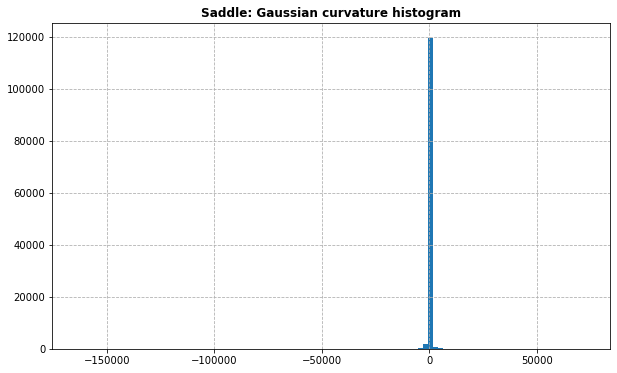

In [57]:
print(principal_curv_saddle.shape)
print(principal_curv_saddle)

gauss_curv_saddle = np.multiply(principal_curv_saddle[:,0], principal_curv_saddle[:,1])

fig = plt.figure(figsize=(10,6))
# plt.subplot(1,2,1)
plt.hist(gauss_curv_saddle, 100)
plt.title("Saddle: Gaussian curvature histogram", fontweight ="bold")
plt.grid(linestyle='--')

# Part V: Course Feedback

### 1. How many hours did you spend on this homework?
Answer: Roughly between 30-40 hrs

### 2. How many hours did you spend on the course each week?
Answer: Initial weeks - approx. 10-15 hrs/week, Last 2 weeks - approx. 30-40 hrs/week
    
### 3. Do you have any course related feedback?
Answer:
- The assignment was a bit time consuming compared to other course's assignments

## References

- https://minibatchai.com/sampling/2021/08/07/FPS.html
- https://trimsh.org/trimesh.geometry.html
- 

## Acknowledgements

I had discussion about some of the problems while doing this assignment with my following classmates:
- Chinmay Talegoankar
- Sambaran Ghosal
- Srinidhi